<a href="https://colab.research.google.com/github/iyoob-utexas/ds4e/blob/main/notebooks/n6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

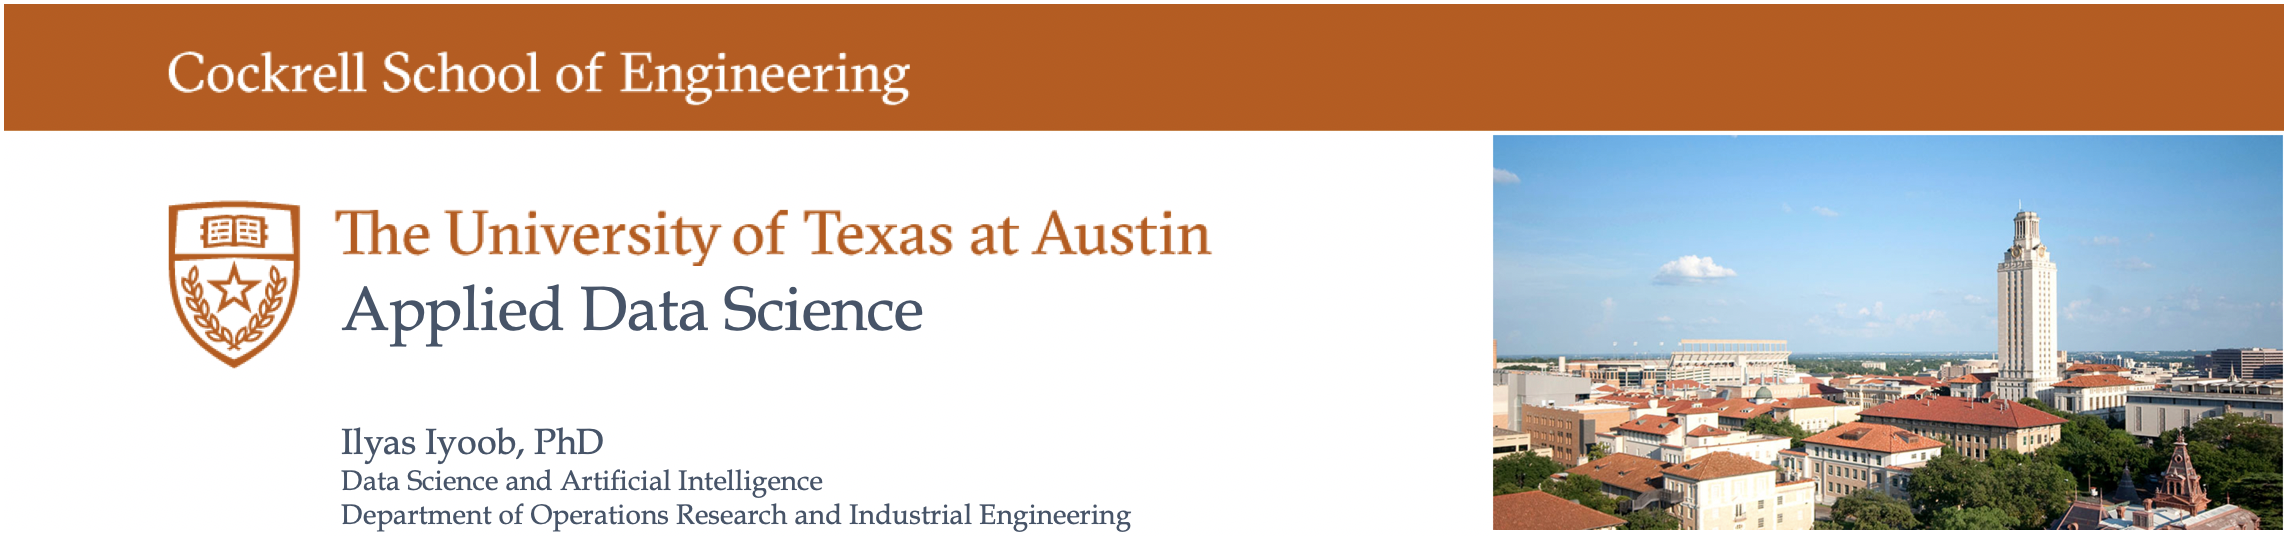

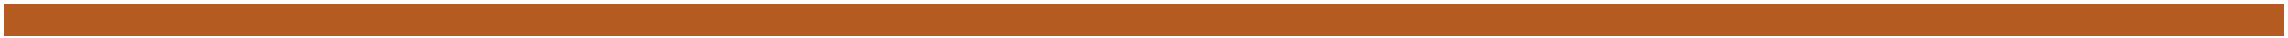

## <font color='#475468'> Customer Segmentation:</font> 
### <font color='#475468'> Can you segment customers by purchasing behavior?</font> 

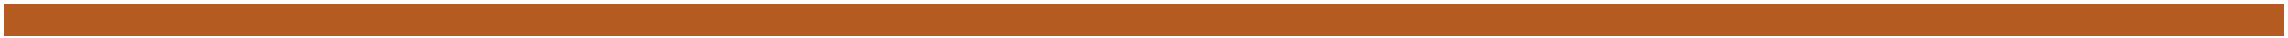

## Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dfRet =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/retail/retail_transactions.csv', encoding = "ISO-8859-1")

In [ ]:
dfRet.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


WHITEBOARD >>

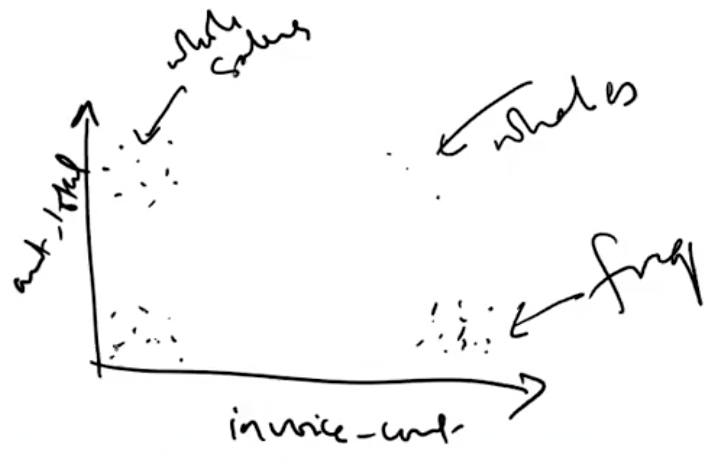

<< WHITEBOARD

## Prepare Data

In [ ]:
# Calculate row total amount
dfRet['total'] = dfRet['Quantity']*dfRet['UnitPrice']
dfRet.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [ ]:
# Aggregate by customer ID
dfRtc = (dfRet.groupby('CustomerID').agg({"InvoiceNo": pd.Series.nunique,"total": np.sum})
             .rename(columns={'InvoiceNo':'invoice_count', 'total':'invoice_amt_total'})
             .reset_index(drop=True)
            )

In [ ]:
# Filter only positive invoices
dfRtc = dfRtc[dfRtc['invoice_amt_total']>0]
dfRtc.describe()

,invoice_count,invoice_amt_total
count,4322.000000,4.322000e+03
mean,5.115687,1.923483e+03
std,9.384459,8.263128e+03
min,1.000000,1.243450e-14
25%,1.000000,3.022925e+02
50%,3.000000,6.575500e+02
75%,6.000000,1.625740e+03
max,248.000000,2.794890e+05


In [ ]:
X = dfRtc
X[X.columns] = scale(X[X.columns])

Note that previously we had a 'Target' column named 'y' which is what we used to train our models on.  In those models our learning was *Supervised* by the previously defined Target values.  However, in this dataset, there is no indication of prior grouping of the customers, so we are going to have to learn something about the data in an *Unsupervised Learning* manner.

In order to segment the customers, let's start by a random assignment and then *Iteratively* improve the result.

### K-Means Clustering

In order to segment the customers, let's start by randomly assigning them to 'n' clusters.  Thereafter, each customer is reassigned to another cluster that it is closer to, and this process is repeated until no more improvements are possible.  This method is known as **K-Means Clustering**.

WHITEBOARD >>

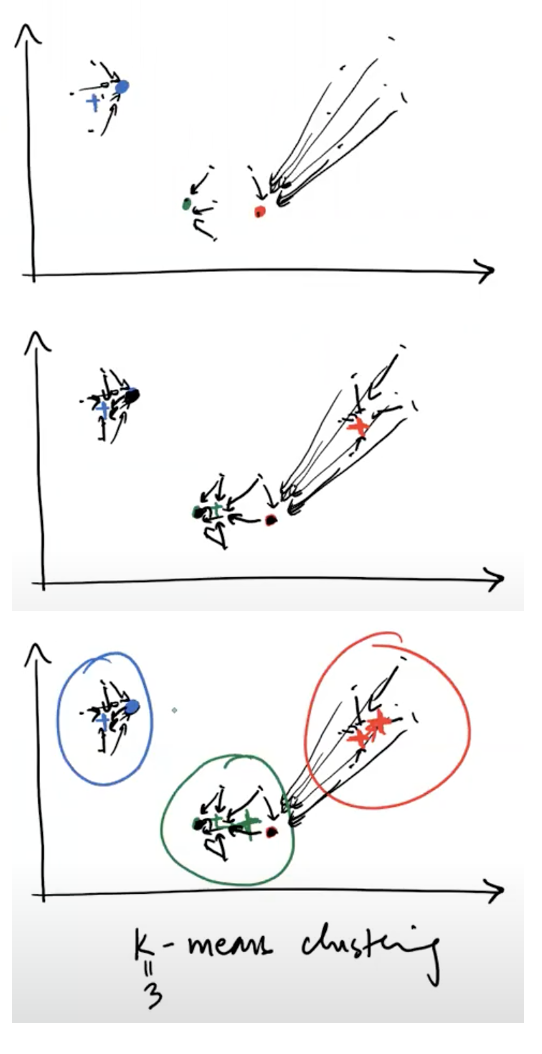

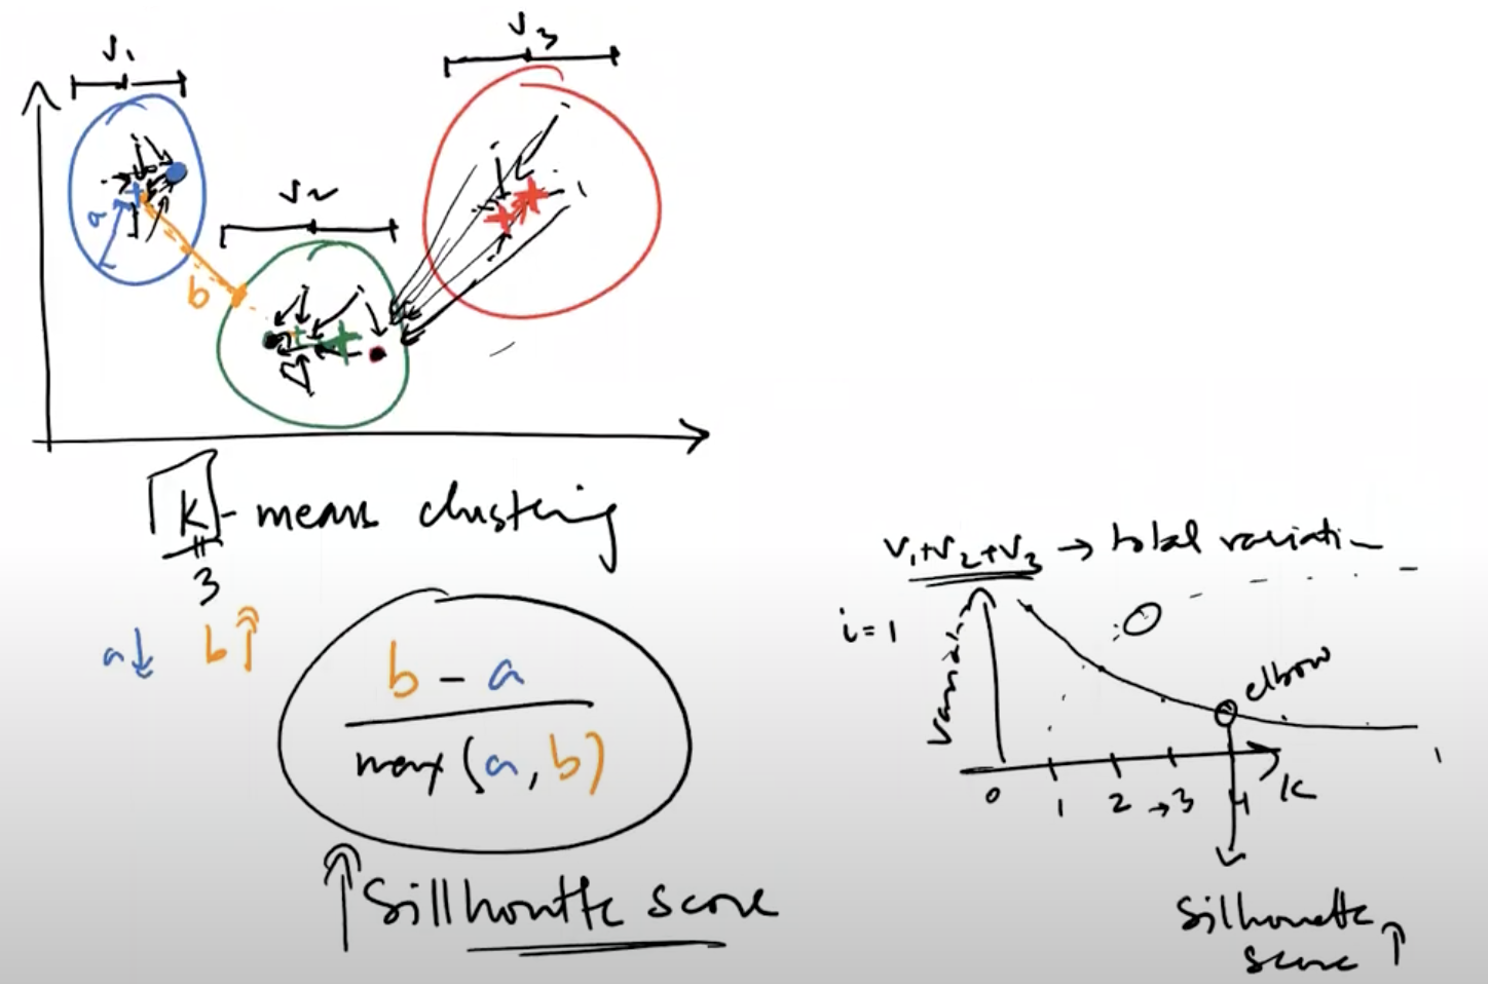

<< WHITEBOARD

In [ ]:
# Build k-Means Clustering model

from sklearn.cluster import KMeans

mdlKmcRtc = KMeans(n_clusters=3, random_state=1)
mdlKmcRtc.fit(X)
kMeans_labels = mdlKmcRtc.labels_

Text(0.5, 1.0, 'K-Means Clustering')

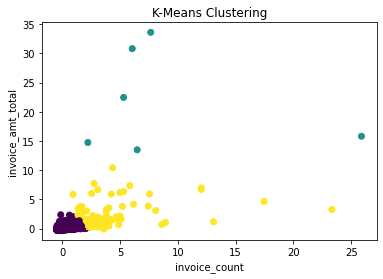

In [ ]:
# Display k-Means cluster on scatter plot

plt.scatter(X['invoice_count'],X['invoice_amt_total'],c=kMeans_labels)
plt.xlabel('invoice_count')
plt.ylabel('invoice_amt_total')
plt.title('K-Means Clustering')

Since we don't have a ground-truth to calculate an accuracy score (like we did in Supervised Learning), we will need to measure how similar an object is to its own cluster (cohesion) compared to other clusters (separation).  This is known as the **Silhouette Score**. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [ ]:
# Evaluate quality of clusters
from sklearn.metrics import silhouette_score

silhouette_score(X, mdlKmcRtc.labels_)

0.8702675789179637

In [ ]:
# Function for K-means Clustering
def cluster_kMeans(X, k):
    mdlKmcRtc = KMeans(n_clusters=k, random_state=1)
    mdlKmcRtc.fit(X)
    kMeans_labels = mdlKmcRtc.labels_
    kMeans_sil_score = silhouette_score(X, mdlKmcRtc.labels_)
    return (kMeans_labels, kMeans_sil_score)

In [ ]:
# Iterate over different values of k to determine best silhouette score

for k in [2, 3, 4, 5, 6]:
    kMeans_labels, kMeans_sil_score = cluster_kMeans(X,k)
    print('k: ',k,'\t\t', 'Silhouette Score: ', kMeans_sil_score)

k:  2 		 Silhouette Score:  0.9500287241902932
k:  3 		 Silhouette Score:  0.8702675789179637
k:  4 		 Silhouette Score:  0.7664562049850545
k:  5 		 Silhouette Score:  0.7548345285634424
k:  6 		 Silhouette Score:  0.6668477797116159


The best cluster size seems to be '2' at which the Silhouette Score is 0.95.

Let's see if we can improve the customer segmentation by starting with each customer in its own cluster and then *Hierarchically* grouping them together... (This is only possible when the dataset is small)

### Hierarchical Clustering

**Hierarchical clustering**, as the name suggests is an algorithm that builds hierarchy of clusters. This algorithm starts with all the data points assigned to a cluster of their own. Then two nearest clusters are merged into the same cluster. In the end, this algorithm terminates when there is only a single cluster left.

WHITEBOARD >>

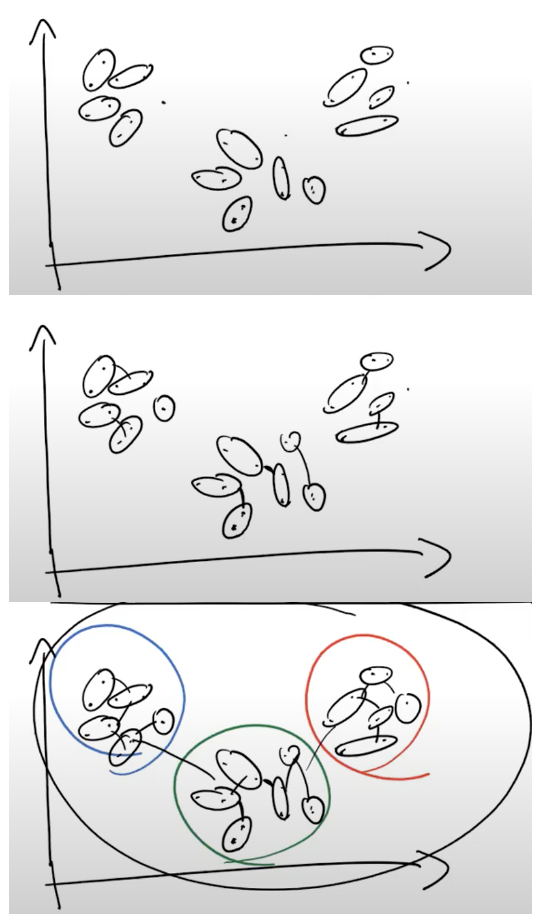

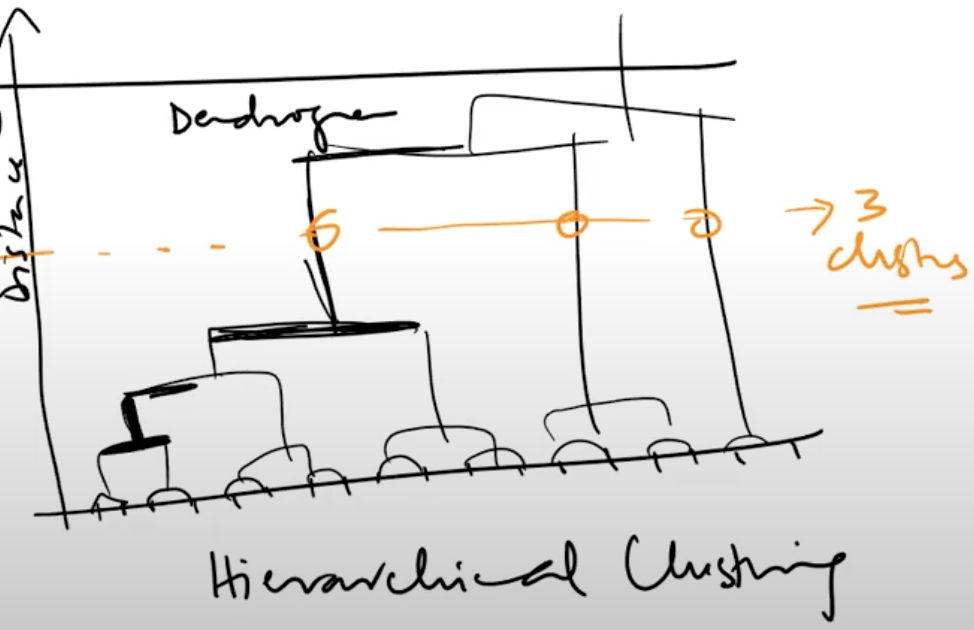

<< WHITEBOARD

In [ ]:
# Generate linkages between data points
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X, 'ward')

Text(0.5, 1.0, 'Hierarchical Clustering')

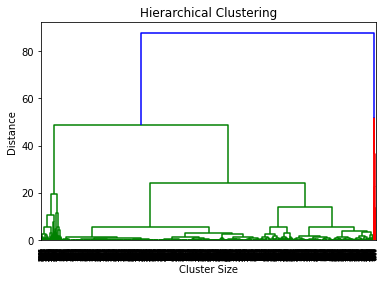

In [ ]:
# Visualize Dendrogram of Clusters

hierarchy.dendrogram(Z)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering')

In [ ]:
# Build Hierarchical Clustering model
from sklearn.cluster import AgglomerativeClustering

mdlHrcRtc = AgglomerativeClustering(n_clusters=3)
mdlHrcRtc.fit(X)
hClust_labels = mdlHrcRtc.labels_

In [ ]:
silhouette_score(X, mdlHrcRtc.labels_)

0.9431829024504798

Text(0.5, 1.0, 'Hierarchical Clustering')

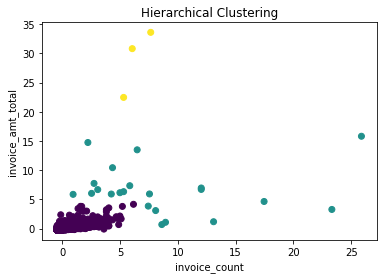

In [ ]:
# Display Hierarchical cluster on scatter plot

plt.scatter(X['invoice_count'],X['invoice_amt_total'],c=hClust_labels)
plt.xlabel('invoice_count')
plt.ylabel('invoice_amt_total')
plt.title('Hierarchical Clustering')

In [ ]:
# Function for Hierarchical Clustering
def cluster_hierarchy(X, k):
    mdlHrcRtc = AgglomerativeClustering(n_clusters=k)
    mdlHrcRtc.fit(X)
    hClust_labels = mdlHrcRtc.labels_
    hClust_sil_score = silhouette_score(X, mdlHrcRtc.labels_)
    return (hClust_labels, hClust_sil_score)

In [ ]:
# Iterate over different values of k to determine best silhouette score

for k in [2, 3, 4, 5, 6]:
    hClust_labels, hClust_sil_score = cluster_hierarchy(X,k)
    print('k: ',k,'\t\t', 'Silhouette Score: ', hClust_sil_score)

k:  2 		 Silhouette Score:  0.9506143839088965
k:  3 		 Silhouette Score:  0.9431829024504798
k:  4 		 Silhouette Score:  0.7878666664053137
k:  5 		 Silhouette Score:  0.7886621064730744
k:  6 		 Silhouette Score:  0.5574243398495589


Even in Hierarchical Clustering, the ideal cluster size is '2', which is reassuring.  However, the cluster labels seem to be slightly better now with a Silhouette Score of 0.9506 over the score of 0.95 in K-Means Clustering.

Let's take a step back, and think about how we as human beings group data points together.  We typically look for dense regions and draw a boundary around it.  We also ignore anomalous datapoints far away from dense regions.  Such models are known as density based models... ideal for data that follows patterns.

utexas_ds_orie_divider_gray.png

### DBScan Clustering and Anomaly Detection

DBScan stands for Density-Based Spatial Clustering of Applications with Noise.  Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

WHITEBOARD >>

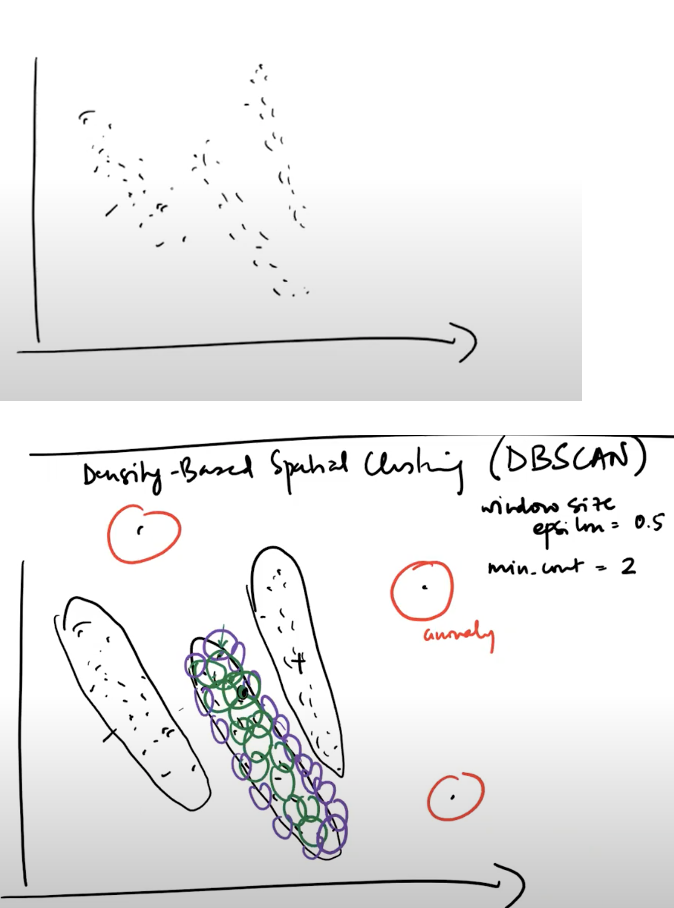

<< WHITEBOARD

In [ ]:
# Build DBScan model

from sklearn.cluster import DBSCAN

mdlDbsRtc = DBSCAN(eps=0.3)
mdlDbsRtc.fit(X)
dbscan_labels = mdlDbsRtc.labels_

In [ ]:
silhouette_score(X, mdlDbsRtc.labels_)

0.9088633547649412

In [ ]:
# Number of clusters in labels, ignoring noise if present.
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_noise = list(dbscan_labels).count(-1)

print('Clusters: ', dbscan_clusters, '\t\t', 'Noise: ', dbscan_noise)

Clusters:  1 		 Noise:  74


Text(0.5, 1.0, 'DBScan Clustering')

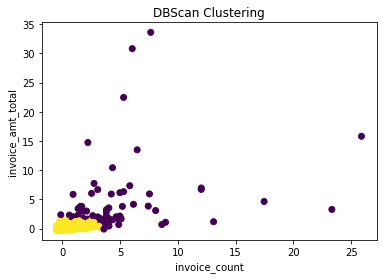

In [ ]:
# Display DBScan cluster on scatter plot

plt.scatter(X['invoice_count'],X['invoice_amt_total'],c=dbscan_labels)
plt.xlabel('invoice_count')
plt.ylabel('invoice_amt_total')
plt.title('DBScan Clustering')

In [ ]:
# Function for DBScan Clustering

def cluster_dbscan(X, eps):
    mdlDbsRtc = DBSCAN(eps)
    mdlDbsRtc.fit(X)
    dbscan_labels = mdlDbsRtc.labels_
    dbscan_sil_score = silhouette_score(X, dbscan_labels)
    
    # count number of clusters and noise points
    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    dbscan_noise = list(dbscan_labels).count(-1)
    return(dbscan_labels, dbscan_sil_score, dbscan_clusters, dbscan_noise)

In [ ]:
# Iterate over different values of eps to determine best silhouette score

for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    dbscan_labels, dbscan_sil_score, dbscan_clusters, dbscan_noise = cluster_dbscan(X, eps)
    print('eps: ',eps,'\t', 'Clusters: ', dbscan_clusters, '\t', 'Noise: ', dbscan_noise, '\t', 'Silhouette Score: ', dbscan_sil_score)

eps:  0.1 	 Clusters:  24 	 Noise:  232 	 Silhouette Score:  0.44530659095141617
eps:  0.2 	 Clusters:  1 	 Noise:  109 	 Silhouette Score:  0.8838266088521828
eps:  0.3 	 Clusters:  1 	 Noise:  74 	 Silhouette Score:  0.9088633547649412
eps:  0.4 	 Clusters:  2 	 Noise:  60 	 Silhouette Score:  0.8714891240418919
eps:  0.5 	 Clusters:  3 	 Noise:  43 	 Silhouette Score:  0.8266426230939371
eps:  0.6 	 Clusters:  3 	 Noise:  34 	 Silhouette Score:  0.824933052572887
eps:  0.7 	 Clusters:  2 	 Noise:  32 	 Silhouette Score:  0.8325865310645006


The highest Silhouette Score in the DBScan model is for a cluster size '1', but it really means there would be 2 clusters where the second cluster is a collection of all the outliers.  However, the Hierarchical Clustering model gave better results which makes sense because in this case we don't have reason to believe that density plays a big role.

Even though we may not choose DBScan in this case, it is still useful in determining outliers.  

## Takeaways

* Introduced unsupervised learning problems to cluster data points using *K-Means Clustering* and *Hierarchical Clustering* 
* Explored a different method of clustering and anomaly detection using density via *DBScan*
* Evaluated the performance of such unsupervised learning models via the *Silhouette Score* due to the absence of ground-truth information

WHITEBOARD >>

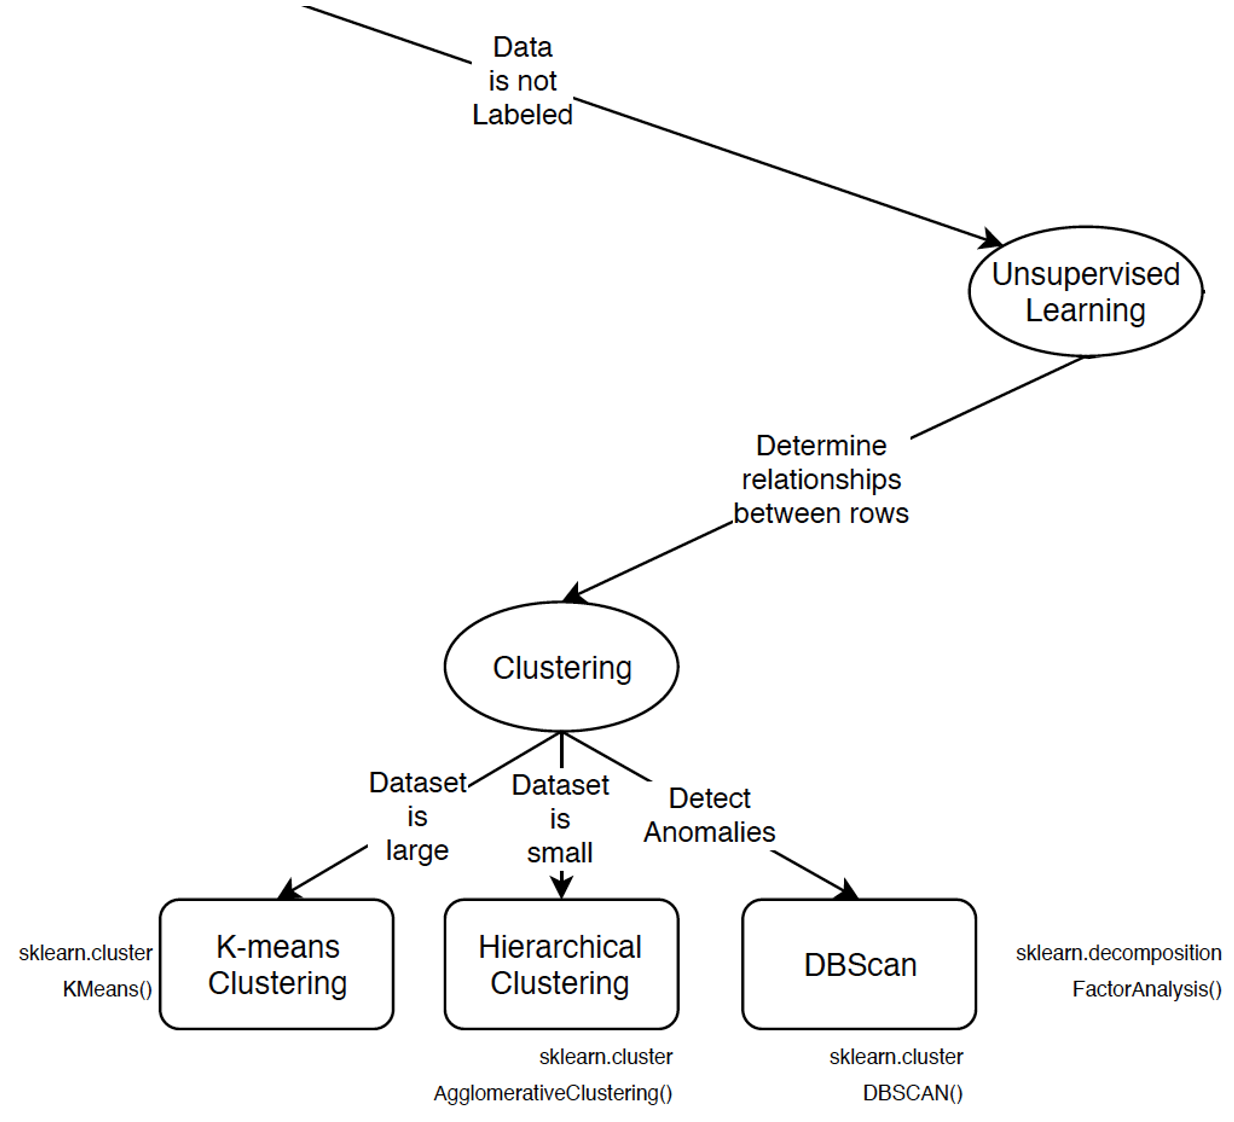

<< WHITEBOARD

utexas_ds_orie_divider_gray.png